#### Установка и импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

import warnings
warnings.filterwarnings('ignore')

In [2]:
def display_with_heading(heading, data):
    '''
    Функция для красивого отображения
    датафреймов с заголовком сверху
    
    heading — (str) — заголовок
    data — (pandas dataframe) — dataframe
    '''
    
    print(f'{heading}:')
    display(data)

#### Загрузка и предварительное изучение датасета

In [3]:
# загрузка данных A/B-теста
try:
    exp_data = pd.read_csv(
        'datasets/sollmafin_abt.csv',
        parse_dates=[
            'first_ts', 
            'first_dt', 
            'event_ts',
        ]
    )
    
except:
    exp_data = pd.read_csv(
        'https://code.s3.yandex.net/datasets/pa_sollmafin_abt.csv',
        parse_dates=[
            'first_ts', 
            'first_dt', 
            'event_ts',
        ]
    )
    
display_with_heading(
    'Данные эксперимента',
    exp_data.head()
)

print('Информация о датасете exp_data:\n')
exp_data.info()

Данные эксперимента:


,user_id,country_code,platform,first_ts,first_dt,event_ts,event_name,ab_test,group,amount,asset,risk_level
0,c430acb5-c6bf-43cf-8e2d-7ab9ce0d2c8a,BR,mobile,2025-06-07 19:55:51,2025-06-07,2025-06-07 19:55:51,install / open_web,onboarding_test,test,NaN,NaN,NaN
1,c430acb5-c6bf-43cf-8e2d-7ab9ce0d2c8a,BR,mobile,2025-06-07 19:55:51,2025-06-07,2025-06-07 19:55:54,introduction,onboarding_test,test,NaN,NaN,NaN
2,c430acb5-c6bf-43cf-8e2d-7ab9ce0d2c8a,BR,mobile,2025-06-07 19:55:51,2025-06-07,2025-06-08 06:18:09,registration,onboarding_test,test,NaN,NaN,NaN
3,c430acb5-c6bf-43cf-8e2d-7ab9ce0d2c8a,BR,mobile,2025-06-07 19:55:51,2025-06-07,2025-06-08 06:18:13,main_page,onboarding_test,test,NaN,NaN,NaN
4,c430acb5-c6bf-43cf-8e2d-7ab9ce0d2c8a,BR,mobile,2025-06-07 19:55:51,2025-06-07,2025-06-08 06:33:40,onboarding_complete,onboarding_test,test,NaN,NaN,NaN


Информация о датасете exp_data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54805 entries, 0 to 54804
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       54805 non-null  object        
 1   country_code  54805 non-null  object        
 2   platform      54805 non-null  object        
 3   first_ts      54805 non-null  datetime64[ns]
 4   first_dt      54805 non-null  datetime64[ns]
 5   event_ts      54805 non-null  datetime64[ns]
 6   event_name    54805 non-null  object        
 7   ab_test       54805 non-null  object        
 8   group         54805 non-null  object        
 9   amount        7843 non-null   float64       
 10  asset         3750 non-null   object        
 11  risk_level    3750 non-null   object        
dtypes: datetime64[ns](3), float64(1), object(8)
memory usage: 5.0+ MB


**Промежуточный вывод:** 
- на первый взгляд данные соответствуют описанию, но нужно посмотреть на уникальные значения в столбцах с категорийными переменными, а также на диапазоны значений в столбцах с переменными численного типа и датами
- типы данных подходящие
- есть пропуски в столбцах `amount`, `asset`, `risk_level`, но пропуски объяснимы смыслом столбцов

In [4]:
# посмотрим на значения в
# столбцах с категорийными переменными

category_columns = [
    'country_code', 'platform', 'group',
    'event_name', 'asset', 'risk_level'
]

for column in category_columns:
    display_with_heading(
        f'Уникальные значения столбца {column}',
        list(exp_data[column].unique())
    )
    print('\n')

Уникальные значения столбца country_code:


['BR', 'MX', 'CO', 'AR']



Уникальные значения столбца platform:


['mobile', 'web']



Уникальные значения столбца group:


['test', 'control']



Уникальные значения столбца event_name:


['install / open_web',
 'introduction',
 'registration',
 'main_page',
 'onboarding_complete',
 'first_deposit',
 'asset_purchase',
 'second_deposit']



Уникальные значения столбца asset:


[nan, 'crypto', 'stock', 'option']



Уникальные значения столбца risk_level:


[nan, 'high', 'low', 'medium']

**Промежуточный вывод:** данные столбца `group` соответствуют описанию; значения категориальных переменных в данных A/B-теста соответствуют значениям в исторических данных

In [5]:
# посмотрим на диапазоны значений столбцов
# с численными значениями и датами

columns = [
    'first_ts', 'first_dt',
    'event_ts', 'amount'
]

for column in columns:
    print(
        f'Диапазон значений столбца {column}: '
        + f'{exp_data[column].min()} - '
        + f'{exp_data[column].max()}'
    )

Диапазон значений столбца first_ts: 2025-06-02 00:27:50 - 2025-06-15 23:58:39
Диапазон значений столбца first_dt: 2025-06-02 00:00:00 - 2025-06-15 00:00:00
Диапазон значений столбца event_ts: 2025-06-02 00:27:50 - 2025-06-22 13:37:05
Диапазон значений столбца amount: 25.0 - 1050.0


**Промежуточный вывод:** верхняя граница диапазона значений столбца `amount` отличается от верхней границы диапазона, полученного на исторических данных (27 - 524) 

In [6]:
# посмотрим на наличие дубликатов в датасете
print(
    'Кол-во полных дубликатов в датафрейме:',
    exp_data.duplicated().sum()
)

Кол-во полных дубликатов в датафрейме: 0


#### Промежуточный вывод (загрузка данных A/B эксперимента и их предобработка):
- в датасете присутствуют все поля, данные соответствуют описанию и бизнес-контексту
- полных дубликатов нет
- в ряде столбцов есть пропуски, но они объяснимы

### Дизайн эксперимента

#### Описание фичи и зона ее влияния на пользователей
После регистрации в приложении пользователь проходит онбординг. При текущем онбординге пользователи часто покупают высокорискованные активы с без понимания последствий. Это приводит к потерям средств пользователей и оттоку пользователей до совершения повторного депозита. Поэтому онбординг был обновлен: в него добавлена детальная информация о различиях финансовых активов и связанных с ними рисках

#### Продуктовая гипотеза
- Гипотеза роста: обучающий онбординг поможет пользователям лучше понимать принципы инвестирования, поэтому они будут чаще открывать второй депозит
- Гипотеза риска: информация о возможных потерях и высоких рисках отпугнёт некоторых новичков, особенно самых осторожных, что снизит конверсию в первый депозит
- Дополнительная гипотеза: после нового онбординга пользователи, которые выбрали высокорискованные активы, будут чаще, чем раньше, возвращаться и открывать второй депозит

Статистические гипотезы сформулированы ниже в ноутбуке

#### Метрики эксперимента:
- ключевая — средняя сумма всех депозитов на одного пользователя
- барьерная — конверсия из регистрации в первый депозит
- вспомогательная 1 — конверсия из первого депозита во второй
- вспомогательная 2 — средняя сумма всех депозитов на платящего пользователя

#### Критерии успеха эксперимента
Ключевая и барьерная метрики не упадут, а вспомогательные покажут значительный рост

#### Cегмент пользователей + способ набора пользователей в группы
В эксперименте участвовали новые пользователи, которые зарегистрировались в приложении со 2 по 15 июня 2025 года. Разделение на группы постепенным сплитом — пользователи набираются в группы по мере того, как регистрируются в приложении

Пользователей случайным образом разделили на две равные группы (50/50): 
- Контрольная группа проходила стандартный онбординг без обязательного обучения
- Тестовая группа проходила обновлённый онбординг с подробной информацией об активах и связанных с ними рисках

#### Ограничения по MDE и длительности эксперимента
После разделения активность пользователей анализировали в течение недели. Строгих требований к MDE нет, результат оценивали после анализа

#### Статистический критерий
- для сравнения средних значений двух выборок (ключевая и вспомогательная 2) используется t-тест Уэлча
- для сравнения конверсий двух выборок (барьерная метрика, вспомогательная метрика 1) используется Z-тест пропорций для двух групп

---

### Исследование результатов А/В эксперимента

1. Анализ аудитории эксперимента (проверка корректности сплита)
2. Сравнение воронок событий в тестовой и контрольной группах
3. Анализ метрик А/В-эксперимента (проверка статистической значимости различий метрик между группами эксперимента)
4. Изучение влияния новой фичи на конверсию во второй депозит с учётом уровня риска купленного актива (оценить, есть ли статистически значимое различие между группами)

#### 1. Анализ аудитории эксперимента

Проверим отсутствие пересечений между группами, размеры групп. Изучим распределение в группах по платформам, странам, по уровню риска купленных активов

In [7]:
# проверим, что группы не пересекаются
# + размеры групп

groups = exp_data.group.unique()

dict_user_test_groups = {}

for group in groups:
    users = (
        exp_data[
            exp_data.group == group
        ]
    )

    dict_user_test_groups[group] = users.user_id.unique().tolist()
    
# проверим, что нет пользователей,
# которые находятся одновременно в
# двух экспериментальных группах

intersection = (
    set(dict_user_test_groups[groups[0]])
    & (set(dict_user_test_groups[groups[1]]))
)
        
if intersection:
    print(f'Есть одинаковые пользователи в {groups[0]} группе и {groups[1]} группе')
else:
    print(f'Нет одинаковых пользователей в {groups[0]} группе и {groups[1]} группе')
    
# проверим размеры групп
group_sizes = (
    exp_data
        .groupby('group')
        .agg(size=('user_id', 'nunique'))
)

total_users = exp_data.user_id.nunique()

group_sizes['size_%'] = round(
    100 * group_sizes['size']
    / total_users, 1
)

display(group_sizes)

Нет одинаковых пользователей в test группе и control группе


,size,size_%
group,,
control,4847,51.5
test,4568,48.5


**Промежуточный вывод:** 

Группы не пересекаются, размеры групп близки

##### Изучим распределение пользователей в группах по странам и используемым платформам

In [8]:
# parameter = 'country_code'
parameter = 'platform'

# посмотрим на кол-во пользователей,
# совершивших покупку активов 
# различных рисков
exp_data_gr = (
    exp_data
        .groupby(['group', parameter])
        .agg(users=('user_id', 'nunique'))
        .reset_index()
)

# посчитаем общее кол-во пользователей,
# совершивших покупку активов
exp_data_gr_total = (
    exp_data
        .groupby(['group'])
        .agg(total_users=('user_id', 'nunique'))
        .reset_index()
)

# объединим информацию
exp_data_gr = pd.merge(
    exp_data_gr,
    exp_data_gr_total,
    on='group',
    how='left'
)

exp_data_gr['users_%'] = round(
    100 * exp_data_gr['users']
    / exp_data_gr['total_users'], 1
)

display_with_heading(
    f'Распределение по {parameter} в экспериментальных группах',
    exp_data_gr
)

Распределение по platform в экспериментальных группах:


,group,platform,users,total_users,users_%
0,control,mobile,3385,4847,69.8
1,control,web,1462,4847,30.2
2,test,mobile,3246,4568,71.1
3,test,web,1322,4568,28.9


In [9]:
# проверим равенство долей с помощью 
# статистического теста Z-теста пропорций
# H_0: статистически значимого различия
# долей нет; H_1: есть (двуст. альт. гип.)

alpha = 0.05

for platform in ['mobile', 'web']:
    control_size = (
        exp_data[
            exp_data['group'] == 'control'
        ]['user_id'].nunique()
    )

    control_platform = (
        exp_data[
            (exp_data['group'] == 'control')
            & (exp_data['platform'] == platform)
        ]['user_id'].nunique()
    )

    test_size = (
        exp_data[
            exp_data['group'] == 'test'
        ]['user_id'].nunique()
    )

    test_platform = (
        exp_data[
            (exp_data['group'] == 'test')
            & (exp_data['platform'] == platform)
        ]['user_id'].nunique()
    )
    
    stat, pval = proportions_ztest(
        [control_platform, test_platform], # кол-во успехов
        [control_size, test_size], # размер выборок
        alternative='two-sided'
    )
    
    print(f'Для платформы {platform}:')
    print(f'p-value = {round(pval, 2)}, ')
    if pval < alpha:
        print('Отвергаем нулевую гипотезу, между долями в группах есть стат. значимая разницы\n')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет статистически значимой разницы между долями в группах\n')

Для платформы mobile:
p-value = 0.19, 
Не получилось отвергнуть нулевую гипотезу, нет статистически значимой разницы между долями в группах

Для платформы web:
p-value = 0.19, 
Не получилось отвергнуть нулевую гипотезу, нет статистически значимой разницы между долями в группах



##### Изучим распределение пользователей в тестовой и контрольной группе по уровню риска купленных активов

Распределение пользователей теста и контроля
по уровню риска купленных активов, % от группы:


group,control,test
risk_level,,
low,16.1,25.1
medium,33.6,37.6
high,50.4,37.3


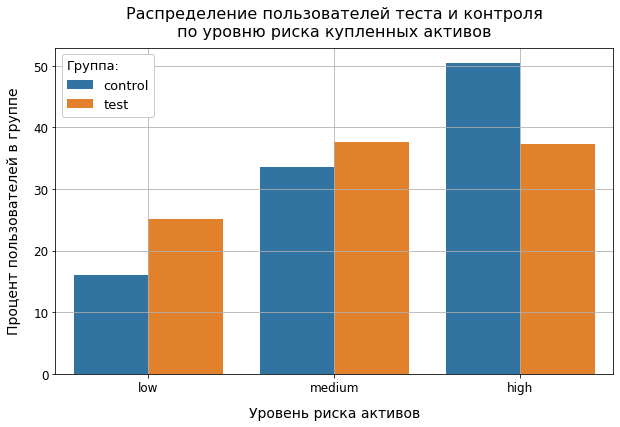

In [10]:
parameter = 'risk_level'

# посмотрим на кол-во пользователей,
# совершивших покупку активов 
# различных рисков
exp_data_gr = (
    exp_data[
        exp_data.event_name == 'asset_purchase'
    ]
        .groupby(['group', parameter])
        .agg(users=('user_id', 'nunique'))
        .reset_index()
)

# посчитаем общее кол-во пользователей,
# совершивших покупку активов
exp_data_gr_total = (
    exp_data[
        exp_data.event_name == 'asset_purchase'
    ]
        .groupby(['group'])
        .agg(total_users=('user_id', 'nunique'))
        .reset_index()
)

# объединим информацию
exp_data_gr = pd.merge(
    exp_data_gr,
    exp_data_gr_total,
    on='group',
    how='left'
)

exp_data_gr['users_%'] = round(
    100 * exp_data_gr['users']
    / exp_data_gr['total_users'], 1
)

# выведем сравнительную таблицу
data_for_plot = (
    exp_data_gr[['group', 'risk_level', 'users_%']]
        .pivot(
            values='users_%', 
            columns='group', 
            index='risk_level'
        )
        .reindex(['low', 'medium', 'high'])
)

display_with_heading(
    'Распределение пользователей теста и контроля'
    +'\nпо уровню риска купленных активов, % от группы',
    data_for_plot
)

# визуализируем
plt.figure(figsize=(10,6))

sns.barplot(
    data=exp_data_gr.reindex([1, 2, 0, 4, 5, 3]), 
    x='risk_level', 
    y='users_%', 
    hue='group')

plt.title(
    'Распределение пользователей теста и контроля'
    +'\nпо уровню риска купленных активов',
    fontsize=16,
    pad=12,
)

plt.xlabel(
    'Уровень риска активов',
    fontsize=14,
    labelpad=12,
)

plt.ylabel(
    'Процент пользователей в группе',
    fontsize=14,
    labelpad=12,
)

plt.tick_params(
   labelsize=12 
)

plt.grid()
plt.legend(
    fontsize=13,
    title='Группа:',
    title_fontsize=13,
    alignment='left',
    framealpha=1,
)

plt.show()

#### Вывод  по анализу аудитории эксперимента

- Распределение пользователей между тестовой и контрольной группами около 50/50 
- Тестовая и контрольная группы не пересекаются между собой
- Распределение по платформам и странам между группами похоже; статистически значимой разницы между долями нет
- Распределение по уровню риска купленных активов отличается: контрольная группа на ~50% состоит из пользователей, которые купили высокорискованные активы, тестовая — менее чем на 40%. Это объяснимо введением в онбординг обучения с информацией об активах и связанных с ними рисках

#### 2. Сравнение воронок событий в тестовой и контрольной группах

In [11]:
funnel_groups = {}

# ранее отобрали шаги воронки
events_order = [
    'install / open_web',
    'introduction',
    'registration',
    'main_page',
    'onboarding_complete',
    'first_deposit',
    'asset_purchase',
    'second_deposit'
]
    
funnel_groups['event'] = events_order

for group in groups:
    exp_data_slice = (
        exp_data[
            exp_data['group'] == group
        ]
    )
    
    funnel = (
        exp_data_slice
            .groupby('event_name')
            .agg(total_users=('user_id', 'nunique'))
            .reindex(events_order)
            .reset_index()
    )
    
    funnel['users_%_from_first'] = round(
        100 * funnel['total_users'] 
        / funnel['total_users'].iloc[0], 1
    )

    funnel['users_%_from_prev'] = round(
        100 * funnel['total_users'] 
        / funnel['total_users'].shift(1), 1
    )
    
    funnel_groups[f'{group}_classic'] = funnel['users_%_from_first']
    funnel_groups[f'{group}_step_by_step'] = funnel['users_%_from_prev']
    
funnel_groups_df = pd.DataFrame(funnel_groups)

display_with_heading(
    'Путь пользователей в контрольной и тестовой группах:',
    funnel_groups_df
)

Путь пользователей в контрольной и тестовой группах::


,event,test_classic,test_step_by_step,control_classic,control_step_by_step
0,install / open_web,100.0,NaN,100.0,NaN
1,introduction,100.0,100.0,100.0,100.0
2,registration,93.4,93.4,93.1,93.1
3,main_page,85.8,91.9,85.8,92.2
4,onboarding_complete,75.8,88.3,83.8,97.6
5,first_deposit,65.4,86.3,66.6,79.4
6,asset_purchase,43.3,66.2,36.6,54.9
7,second_deposit,21.3,49.3,13.5,36.9


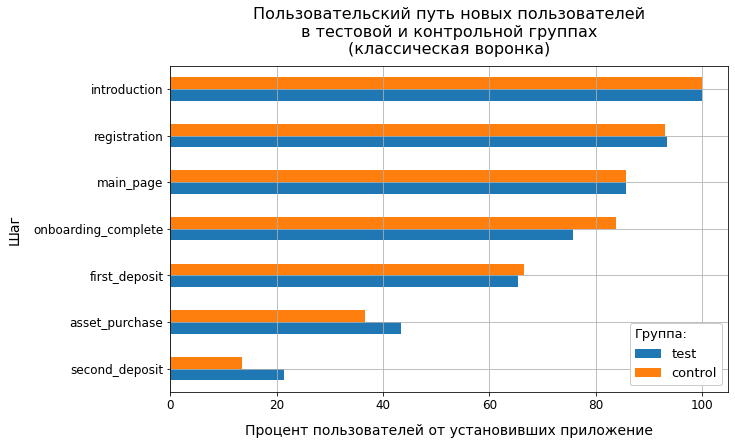

In [12]:
# визуализируем классическую воронку, 
# начиная с шага 'introduction'

funnel_groups_df[:0:-1].plot.barh(
    y=['test_classic', 'control_classic'], 
    x='event',
    label=['test', 'control'],
    figsize=(10,6),
    grid=True,
)

plt.title(
    'Пользовательский путь новых пользователей'
    +'\nв тестовой и контрольной группах'
    +'\n(классическая воронка)',
    fontsize=16,
    pad=12,
)

plt.xlabel(
    'Процент пользователей от установивших приложение',
    fontsize=14,
    labelpad=12,
)

plt.ylabel(
    'Шаг',
    fontsize=14,
    labelpad=12,
)

plt.tick_params(
   labelsize=12 
)

plt.grid()
plt.legend(
    fontsize=13,
    title='Группа:',
    title_fontsize=13,
    alignment='left',
    framealpha=1,
)

plt.legend(
    fontsize=13,
    title='Группа:',
    title_fontsize=13,
    alignment='left',
    framealpha=1,
)

plt.grid()

plt.show()

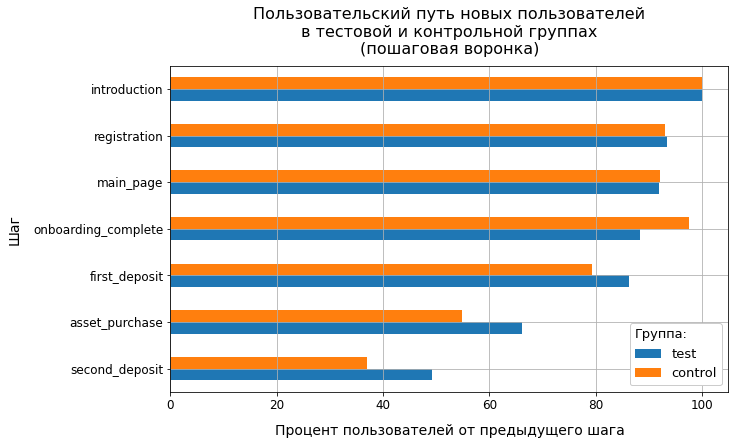

In [13]:
# визуализируем пошаговую воронку, 
# начиная с шага 'introduction'

funnel_groups_df[:0:-1].plot.barh(
    y=['test_step_by_step', 'control_step_by_step'], 
    x='event',
    label=['test', 'control'],
    figsize=(10,6),
    grid=True,
)

plt.title(
    'Пользовательский путь новых пользователей'
    +'\nв тестовой и контрольной группах'
    +'\n(пошаговая воронка)',
    fontsize=16,
    pad=12,
)

plt.xlabel(
    'Процент пользователей от предыдущего шага',
    fontsize=14,
    labelpad=12,
)

plt.ylabel(
    'Шаг',
    fontsize=14,
    labelpad=12,
)

plt.tick_params(
   labelsize=12 
)

plt.grid()
plt.legend(
    fontsize=13,
    title='Группа:',
    title_fontsize=13,
    alignment='left',
    framealpha=1,
)

plt.legend(
    fontsize=13,
    title='Группа:',
    title_fontsize=13,
    alignment='left',
    framealpha=1,
)

plt.grid()

plt.show()

#### Вывод по сравнению воронок событий в тестовой и контрольной группах

- В тестовой группе меньше пользователей доходит до завершения онбординга. Это может быть объяснимо тем, что онбординг в тестовой группе дополнен обучением, т.е. он сложнее и дольше, чем в контрольной
- В тестовой группе бóльшая доля пользователей переходит к совершению первого депозита после онбординга, а также больше пользователей совершают покупку активов и повторный депозит. Возможно, предположение команды верно и пользователи, обладающие подробной информацией об активах и связанных с ними рисках, легче покупают активы и имеют большую вовлеченность

#### 3. Анализ метрик А/В-эксперимента

Для каждой метрики выведем: значения в контрольной и тестовой группах, абсолютные и относительные изменения значений в тестовой группе по сравнению с контрольной. После этого проверим статистическую значимость различий метрик между группами эксперимента. 

##### Ключевая метрика — сумма всех депозитов на одного пользователя

In [14]:
# считаем кол-во пользователей
# и общую сумму депозитов по группам
exp_data_KPI = (
    exp_data
        .groupby(['group'])
        .agg(
            deposits_total=('amount', 'sum'),
            users_total=('user_id', 'nunique')
        )
)

# считаем сумму депозитов на 
# одного пользователя
exp_data_KPI['deposits_total_per_user'] = round(
    exp_data_KPI['deposits_total']
    / exp_data_KPI['users_total'], 1
)

# транспонируем матрицу, чтобы
# можно было обращаться к значениям
# в тестовой и контрольной группах
# по названиям столбцов
exp_data_KPI = exp_data_KPI[['deposits_total_per_user']].transpose()
exp_data_KPI.columns.name = None
exp_data_KPI = exp_data_KPI.reset_index(names='metric')

display_with_heading(
    'Cредняя сумма всех депозитов на одного пользователя',
    exp_data_KPI
)

Cредняя сумма всех депозитов на одного пользователя:


,metric,control,test
0,deposits_total_per_user,90.2,92.5


##### Барьерная метрика — конверсия из регистрации в первый депозит

In [15]:
exp_data_barrier = (
    exp_data[
        exp_data['event_name'].isin([
            'registration', 'first_deposit'
        ])
    ]
        .groupby(['group', 'event_name'])
        .agg(total_users=('user_id', 'nunique'))
        .reset_index()
)

exp_data_barrier = exp_data_barrier.pivot(
    columns='event_name',
    index='group',
    values='total_users'
)
exp_data_barrier.columns.name = None
exp_data_barrier.index.name = None

exp_data_barrier['CR_to_1_deposit'] = round(
    100 * exp_data_barrier['first_deposit']
    / exp_data_barrier['registration'], 1
)

exp_data_barrier = (
    exp_data_barrier[['CR_to_1_deposit']]
        .transpose()
        .reset_index(names='metric')
)

display_with_heading(
    'Конверсия из регистрации в первый депозит',
    exp_data_barrier
)

Конверсия из регистрации в первый депозит:


,metric,control,test
0,CR_to_1_deposit,71.5,70.0


##### Вспомогательная метрика 1 — конверсия из первого депозита во второй

In [16]:
exp_data_support_1 = (
    exp_data[
        exp_data['event_name'].isin([
            'second_deposit', 'first_deposit'
        ])
    ]
        .groupby(['group', 'event_name'])
        .agg(total_users=('user_id', 'nunique'))
        .reset_index()
)

exp_data_support_1 = exp_data_support_1.pivot(
    columns='event_name',
    index='group',
    values='total_users'
)
exp_data_support_1.columns.name = None
exp_data_support_1.index.name = None

exp_data_support_1['CR_to_2_deposit'] = round(
    100 * exp_data_support_1['second_deposit']
    / exp_data_support_1['first_deposit'], 1
)

exp_data_support_1 = (
    exp_data_support_1[['CR_to_2_deposit']]
        .transpose()
        .reset_index(names='metric')
)

display_with_heading(
    'Конверсия из первого депозита во второй',
    exp_data_support_1
)

Конверсия из первого депозита во второй:


,metric,control,test
0,CR_to_2_deposit,20.3,32.6


##### Вспомогательная метрика 2 — средняя сумма всех депозитов на пользователя, который открыл хотя бы один депозит

In [17]:
users_with_deposit = (
    exp_data[
        exp_data.event_name == 'first_deposit'
    ]['user_id'].unique()
)

exp_data_support_2 = (
    exp_data[
        exp_data['user_id'].isin(users_with_deposit)
    ]
        .groupby(['group'])
        .agg(
            deposits_total=('amount', 'sum'),
            users_total=('user_id', 'nunique')
        )
)

exp_data_support_2['deposits_total_per_paying_user'] = round(
    exp_data_support_2['deposits_total']
    / exp_data_support_2['users_total'], 1
)

exp_data_support_2 = exp_data_support_2[['deposits_total_per_paying_user']].transpose()
exp_data_support_2.columns.name = None
exp_data_support_2 = exp_data_support_2.reset_index(names='metric')

display_with_heading(
    'Cредняя сумма всех депозитов на одного пользователя, открывшего хотя бы один депозит',
    exp_data_support_2
)

Cредняя сумма всех депозитов на одного пользователя, открывшего хотя бы один депозит:


,metric,control,test
0,deposits_total_per_paying_user,135.5,141.4


##### Объединение в датафрейм с результатами и расчет изменения значения в тестовой группе относительно контрольной

In [18]:
# объединим все метрики в один датафрейм
metric_dfs = [
    exp_data_KPI, exp_data_barrier, 
    exp_data_support_1, exp_data_support_2
]

metrics_df = pd.concat(metric_dfs).reset_index(drop=True)

# дополним датафрейм абсолютным
# и относительным изменением значения
# в тестовой группе по сравнению с 
# контрольной
metrics_df['diff_abs'] = (
    metrics_df['test']
    - metrics_df['control']
)

metrics_df['diff_%'] = round(
    100 * metrics_df['diff_abs']
    / metrics_df['control'], 1
)

display_with_heading(
    'Датафрейм с метриками (ключевая, барьерная, вспомогательные)',
    metrics_df
)

Датафрейм с метриками (ключевая, барьерная, вспомогательные):


,metric,control,test,diff_abs,diff_%
0,deposits_total_per_user,90.2,92.5,2.3,2.5
1,CR_to_1_deposit,71.5,70.0,-1.5,-2.1
2,CR_to_2_deposit,20.3,32.6,12.3,60.6
3,deposits_total_per_paying_user,135.5,141.4,5.9,4.4


##### Проверим статистическую значимость различий метрик между группами

Необходимо проверить изменение на значимость, т.е. провести статистический тест. Выбор теста зависит от предпосылок данных и типов метрик. В рамках статистического теста:
1. формулируем нулевую и альтернативную гипотезы
2. определяем уровень статистической значимости (выберем α = 0.05)
3. рассчитываем p-value
4. сравниваем p-value с выбранным уровнем значимости и принимаем решение по отклонению или принятию нулевой гипотезы

Ожидалось, что ключевая и барьерная метрики не упадут, а вспомогательные покажут значительный рост. Исходя из этого **запишем нулевые и альтернативные гипотезы тестов**:<br>
    
1. Ключевая метрика:
- H<sub>0</sub>: значение суммы всех депозитов на одного пользователя в тестовой группе не отличается от значения в контрольной<br>
- H<sub>1</sub>: значение суммы всех депозитов на одного пользователя в тестовой группе отличается от значения в контрольной (двусторонняя альтернативная гипотеза)

2. Барьерная метрика:
- H<sub>0</sub>: значение конверсии из регистрации в первый депозит в тестовой группе не отличается от значения в контрольной<br>
- H<sub>1</sub>: значение конверсии из регистрации в первый депозит в тестовой группе отличается от значения в контрольной (двусторонняя альтернативная гипотеза)

3. Вспомогательная метрика 1:
- H<sub>0</sub>:  значение конверсии из первого депозита во второй в тестовой группе не отличается от значения в контрольной<br>
- H<sub>1</sub>: конверсия из первого депозита во второй в тестовой группе выше, чем в контрольной (односторонняя альтернативная гипотеза)

4. Вспомогательная метрика 2:
- H<sub>0</sub>: значение средней суммы всех депозитов на пользователя, который открыл хотя бы один депозит, в тестовой группе не отличается от значения в контрольной<br>
- H<sub>1</sub>: средняя сумма всех депозитов на пользователя, который открыл хотя бы один депозит, в тестовой группе выше, чем в контрольной (односторонняя альтернативная гипотеза)

**Используемые тесты:**
- Для сравнения средних двух выборок (ключевая метрика, вспомогательная метрика 2) используется двухвыборочный t-тест Стьюдента или t-тест Уэлча. Учитывая, что t-тест Уэлча можно использовать при равных дисперсиях (если дисперсии одинаковы, результаты теста Уэлча будут почти идентичны классическому двухвыборочному t-тесту Стьюдента), выберем t-тест Уэлча<br>
- Для сравнения конверсий двух выборок (барьерная метрика, вспомогательная метрика 1) используется Z-тест пропорций для двух групп

In [19]:
alpha = 0.05
metrics_p_value = {}

In [20]:
# ключевая метрика — средняя сумма 
# всех депозитов на одного пользователя

control = list(
    exp_data[
        exp_data['group'] == 'control'
    ]
        .groupby(['user_id'])
        .agg(
            deposits_total=('amount', 'sum')
        )
        .reset_index()
    ['deposits_total']
)

test = list(
    exp_data[
        exp_data['group'] == 'test'
    ]
        .groupby(['user_id'])
        .agg(
            deposits_total=('amount', 'sum')
        )
        .reset_index()
    ['deposits_total']
)

result_key = st.ttest_ind( 
    control, 
    test, 
    equal_var=False,
    alternative='two-sided' 
)

metrics_p_value['deposits_total_per_user'] = (
    result_key.pvalue
)

if result_key.pvalue < alpha:
    print(f'Ключевая метрика: p-value = {round(result_key.pvalue, 2)} < alpha; отвергаем нулевую гипотезу')
else:
    print(f'Ключевая метрика: p-value = {round(result_key.pvalue, 2)} > alpha; не получилось отвергнуть нулевую гипотезу')

Ключевая метрика: p-value = 0.34 > alpha; не получилось отвергнуть нулевую гипотезу


In [21]:
# барьерная метрика — конверсия из
# регистрации в первый депозит

exp_data_barrier = (
    exp_data[
        exp_data['event_name'].isin([
            'registration', 'first_deposit'
        ])
    ]
        .groupby(['group', 'event_name'])
        .agg(total_users=('user_id', 'nunique'))
        .reset_index()
)

control_reg = int(
    exp_data_barrier[
        (exp_data_barrier.group == 'control')
        & (exp_data_barrier.event_name == 'registration')
    ]['total_users'].iloc[0]
)
test_reg = int(
    exp_data_barrier[
        (exp_data_barrier.group == 'test')
        & (exp_data_barrier.event_name == 'registration')
    ]['total_users'].iloc[0]
)

control_1_dep = int(
    exp_data_barrier[
        (exp_data_barrier.group == 'control')
        & (exp_data_barrier.event_name == 'first_deposit')
    ]['total_users'].iloc[0]
)
test_1_dep = int(
    exp_data_barrier[
        (exp_data_barrier.group == 'test')
        & (exp_data_barrier.event_name == 'first_deposit')
    ]['total_users'].iloc[0]
)

stat_barrier, pval_barrier = proportions_ztest(
    [control_1_dep, test_1_dep], # кол-во успехов
    [control_reg, test_reg], # размер выборок
    alternative='two-sided'
)

metrics_p_value['CR_to_1_deposit'] = (
    pval_barrier
)

if pval_barrier < alpha:
    print(f'Барьерная метрика: p-value = {round(pval_barrier, 2)} < alpha; отвергаем нулевую гипотезу')
else:
    print(f'Барьерная метрика: p-value = {round(pval_barrier, 2)} > alpha; не получилось отвергнуть нулевую гипотезу')

Барьерная метрика: p-value = 0.12 > alpha; не получилось отвергнуть нулевую гипотезу


In [22]:
# вспомогательная метрика 1 — конверсия
# из первого депозита во второй

exp_data_support_1 = (
    exp_data[
        exp_data['event_name'].isin([
            'second_deposit', 'first_deposit'
        ])
    ]
        .groupby(['group', 'event_name'])
        .agg(total_users=('user_id', 'nunique'))
        .reset_index()
)


control_reg = int(
    exp_data_support_1[
        (exp_data_support_1.group == 'control')
        & (exp_data_support_1.event_name == 'first_deposit')
    ]['total_users'].iloc[0]
)
test_reg = int(
    exp_data_support_1[
        (exp_data_support_1.group == 'test')
        & (exp_data_support_1.event_name == 'first_deposit')
    ]['total_users'].iloc[0]
)

control_1_dep = int(
    exp_data_support_1[
        (exp_data_support_1.group == 'control')
        & (exp_data_support_1.event_name == 'second_deposit')
    ]['total_users'].iloc[0]
)
test_1_dep = int(
    exp_data_support_1[
        (exp_data_support_1.group == 'test')
        & (exp_data_support_1.event_name == 'second_deposit')
    ]['total_users'].iloc[0]
)

stat_support_1, pval_support_1 = proportions_ztest(
    [control_1_dep, test_1_dep], # кол-во успехов
    [control_reg, test_reg], # размер выборок
    alternative='smaller'
)

metrics_p_value['CR_to_2_deposit'] = (
    pval_support_1
)

if pval_support_1 < alpha:
    print(f'Вспомогательная метрика 1: p-value = {round(pval_support_1, 2)} < alpha; отвергаем нулевую гипотезу')
else:
    print(f'Вспомогательная метрика 1: p-value = {round(pval_support_1, 2)} > alpha; не получилось отвергнуть нулевую гипотезу')

Вспомогательная метрика 1: p-value = 0.0 < alpha; отвергаем нулевую гипотезу


In [23]:
# вспомогательная метрика 2 — средняя 
# сумма всех депозитов на одного 
# пользователя хотя бы с 1 депозитом

# аналогично ключевой метрике,
# но добавляем условие, что 
# пользователь должен совершить 
# хотя бы один депозит (список
# таких пользователей подготовили ранее
control = list(
    exp_data[
        (exp_data['group'] == 'control')
        & (exp_data['user_id'].isin(users_with_deposit))
    ]
        .groupby(['user_id'])
        .agg(
            deposits_total=('amount', 'sum')
        )
        .reset_index()
    ['deposits_total']
)

test = list(
    exp_data[
        (exp_data['group'] == 'test')
        & (exp_data['user_id'].isin(users_with_deposit))
    ]
        .groupby(['user_id'])
        .agg(
            deposits_total=('amount', 'sum')
        )
        .reset_index()
    ['deposits_total']
)

result_support_2 = st.ttest_ind( 
    control, 
    test, 
    equal_var=False,
    alternative='less'
)

metrics_p_value['deposits_total_per_paying_user'] = (
    result_support_2.pvalue
)

if result_support_2.pvalue < alpha:
    print(f'Вспомогательная метрика 2: p-value = {round(result_support_2.pvalue, 2)} < alpha; отвергаем нулевую гипотезу')
else:
    print(f'Вспомогательная метрика 2: p-value = {round(result_support_2.pvalue, 2)} > alpha; не получилось отвергнуть нулевую гипотезу')

Вспомогательная метрика 2: p-value = 0.02 < alpha; отвергаем нулевую гипотезу


##### Дополним датафрейм с результатами эксперимента

In [24]:
metrics_p_value_df = pd.DataFrame.from_dict(
    metrics_p_value, 
    orient='index', 
    columns=['p_value']
).reset_index(names='metric')

metrics_full_df = metrics_df.merge(
    metrics_p_value_df,
    how='inner',
    on='metric'
)

with pd.option_context('display.float_format', '{:.2f}'.format):
    display_with_heading(
        'Результат анализа метрик A/B эксперимента',
        metrics_full_df
    )

Результат анализа метрик A/B эксперимента:


,metric,control,test,diff_abs,diff_%,p_value
0,deposits_total_per_user,90.20,92.50,2.30,2.50,0.34
1,CR_to_1_deposit,71.50,70.00,-1.50,-2.10,0.12
2,CR_to_2_deposit,20.30,32.60,12.30,60.60,0.00
3,deposits_total_per_paying_user,135.50,141.40,5.90,4.40,0.02


##### Промежуточный вывод:

1. Ключевая и барьерная метрики: не смогли отвергнуть нулевую гипотезу, значение метрики в тестовой группе не отличается от значения метрики в контрольной. Т.е. можно сделать вывод, что ключевая и барьерная метрики не упали. Относительная разница метрик составляет 2.5% (ключевая) и 2.1% (барьерная) 
2. Вспомогательные метрики: отвергли нулевую гипотезу в пользу альтернативной, значение метрики в тестовой группе статистически значимо отличается от значения в контрольной. Т.е. можно сделать вывод, что вспомогательные метрики выросли. Относительная разница метрик составляет 60.6% (вспомогательная 1) и 4.4% (вспомогательная 2)

#### Вывод по анализу метрик А/В-эксперимента

Можно считать эксперимент успешным, т.к.
- Ключевая и барьерная метрики не упали. Относительная разница метрик составляет 2.5% (ключевая) и 2.1% (барьерная) между группами
- Вспомогательные метрики выросли. Относительная разница метрик составляет 60.6% (вспомогательная 1) и 4.4% (вспомогательная 2)

#### 4. Изучение влияния новой фичи на конверсию во второй депозит с учётом уровня риска купленного актива

In [25]:
# отфильтруем данные по имени события
# 'asset_purchase', нас интересуют 
# id пользователей и уровень риска актива
exp_data_risk = (
    exp_data[
        exp_data.event_name == 'asset_purchase'
    ][['user_id', 'risk_level']]
)

# создадим словарь в котором будем
# хранить id пользователей, совершивших 
# покупки активов различного уровня риска
dict_user_groups = {}

risk_levels = exp_data_risk.risk_level.unique()

for risk_level in risk_levels:
    users = (
        exp_data_risk[
            exp_data_risk.risk_level == risk_level
        ]
    )

    dict_user_groups[risk_level] = users.user_id.unique().tolist()
    
# проверим, что нет пользователей,
# которые совершали покупки активов
# различного уровня риска

for i in range (len(risk_levels)):
    for j in range(i + 1, len(risk_levels)):
        level_1 = risk_levels[i]
        level_2 = risk_levels[j]
        
        intersection = (
            set(dict_user_groups[level_1])
            & (set(dict_user_groups[level_2]))
        )
        
        if intersection:
            print(f'Есть одинаковые пользователи в {level_1}-risk группе и {level_2}-risk группе')
        else:
            print(f'Нет одинаковых пользователей в {level_1}-risk группе и {level_2}-risk группе')

# создадим вложенный словарь
conv_dict = {}
conv_dict['test'] = {}
conv_dict['control'] = {}

for group in ['test', 'control']:
    for risk_level in risk_levels:
        conv_data = (
            exp_data[
                (exp_data.user_id.isin(dict_user_groups[risk_level]))
                & (exp_data.event_name.isin(['asset_purchase', 'second_deposit']))
                & (exp_data.group == group)
            ]
        )

        total_users = (
            conv_data
                .groupby('event_name')
                .agg(total_users=('user_id', 'nunique'))
        )

        conv_dict[group][risk_level] = round(
            100 * total_users.loc['second_deposit']['total_users']
            / total_users.loc['asset_purchase']['total_users'], 1
        )


conv_df = (
    pd.DataFrame
        .from_dict(conv_dict, orient='index')
        .transpose()
        .reindex(['low', 'medium', 'high'])
)

# посчитаем, как изменилась конверсия
# в тестовой группе относительно
# контрольной
conv_df['diff'] = conv_df['test'] - conv_df['control']
conv_df['diff_%'] = round(
    100 * conv_df['diff'] 
    / conv_df['control'],
    1
)

display_with_heading(
    '\nКонверсия в повторный депозит от уровня риска купленного актива'
    +'\nв тестовой и контрольной группах',
    conv_df
)

Нет одинаковых пользователей в high-risk группе и low-risk группе
Нет одинаковых пользователей в high-risk группе и medium-risk группе
Нет одинаковых пользователей в low-risk группе и medium-risk группе

Конверсия в повторный депозит от уровня риска купленного актива
в тестовой и контрольной группах:


,test,control,diff,diff_%
low,57.5,49.8,7.7,15.5
medium,47.0,44.5,2.5,5.6
high,46.0,27.7,18.3,66.1


##### Оценим, есть ли статистически значимая разница между группами

Сформулируем нулевую и альтернативную гипотезы (одинаковые для каждой из подгрупп по уровню риска приобретенных активов):
- H<sub>0</sub>: значение конверсии из покупки актива во второй депозит в тестовой группе не отличается от значения в контрольной
- H<sub>1</sub>: конверсия из покупки актива во второй депозит в тестовой группе отличается от значения в контрольной (двусторонняя альтернативная гипотеза, т.к. необходимо определить, есть ли статистически значимая разница между группами)

Т.к. сравниваем конверсии, используем Z-тест пропорций для двух групп. Заметим: рекомендуется, чтобы в каждой выборке было не менее 30 наблюдений + число успехов и неудач в каждой группе должно быть больше 10. В данном случае условия применимости соблюдены, т.к. в выборках число наблюдений порядка сотен, минимальная конверсия 27.7%

Уровень значимости выберем стандартный (α = 0.05)

In [26]:
alpha = 0.05

p_value_3_3 = {}

for risk_level in ['low', 'medium', 'high']:
    control_asset = (
        exp_data[
            (exp_data.user_id.isin(dict_user_groups[risk_level])) 
            & (exp_data.event_name == 'asset_purchase') 
            & (exp_data.group == 'control')
        ]['user_id'].nunique()
    )
    
    control_2_dep = (
        exp_data[
            (exp_data.user_id.isin(dict_user_groups[risk_level])) 
            & (exp_data.event_name == 'second_deposit') 
            & (exp_data.group == 'control')
        ]['user_id'].nunique()
    )
    
    test_asset = (
        exp_data[
            (exp_data.user_id.isin(dict_user_groups[risk_level])) 
            & (exp_data.event_name == 'asset_purchase') 
            & (exp_data.group == 'test')
        ]['user_id'].nunique()
    )
    
    test_2_dep = (
        exp_data[
            (exp_data.user_id.isin(dict_user_groups[risk_level])) 
            & (exp_data.event_name == 'second_deposit') 
            & (exp_data.group == 'test')
        ]['user_id'].nunique()
    )

    stat, pval = proportions_ztest(
        [control_2_dep, test_2_dep], # кол-во успехов
        [control_asset, test_asset], # размер выборок
        alternative='two-sided'
    )
    
    p_value_3_3[risk_level] = pval

    print(f'Для активов уровня риска {risk_level}:')
    print(f'p-value = {round(pval, 2)}, ')
    if pval < alpha:
        print('отвергаем нулевую гипотезу\n')
    else:
        print('не получилось отвергнуть нулевую гипотезу\n')

# добавим в датафрейм со значениями
# конверсий и их абсолютной / относительной
# разницы

p_value_3_3_df = pd.DataFrame.from_dict(
    p_value_3_3, 
    orient='index', 
    columns=['p_value']
)

conv_df_with_pval = conv_df.join(p_value_3_3_df)

with pd.option_context('display.float_format', '{:.2f}'.format):
    display_with_heading(
        '\nКонверсия в повторный депозит от уровня риска купленного актива'
        +'\nв тестовой и контрольной группах',
        conv_df_with_pval
    )

Для активов уровня риска low:
p-value = 0.04, 
отвергаем нулевую гипотезу

Для активов уровня риска medium:
p-value = 0.36, 
не получилось отвергнуть нулевую гипотезу

Для активов уровня риска high:
p-value = 0.0, 
отвергаем нулевую гипотезу


Конверсия в повторный депозит от уровня риска купленного актива
в тестовой и контрольной группах:


,test,control,diff,diff_%,p_value
low,57.50,49.80,7.70,15.50,0.04
medium,47.00,44.50,2.50,5.60,0.36
high,46.00,27.70,18.30,66.10,0.00


#### Вывод по изучению влияния новой фичи на конверсию во второй депозит с учётом уровня риска купленного актива

Конверсия в повторный депозит статистически значимо изменилась в тестовой группе относительно контрольной, в подргуппах пользователей, которые приобретали активы низкого или высокого уровня риска. Изменение в тестовой группе относительно контрольной не значимо для группы пользователей, приобретавших активы среднего уровня риска. Т.е. фича влияет на конверсию во второй депозит тех пользователей, которые приобретают наиболее и наименее рискованные активы (на наиболее и наименее осторожных пользователей)

Наибольший рост (на 66%) конверсии произошел в группе пользователей, купивших активы высокого уровня риска

### Вывод на основе анализа результатов A/B-эксперимента: 
- **Эксперимент можно считать успешным**, т.к. при проведении теста ключевая и барьерная метрики не упали (нет статистически значимой разницы в значении метрики между контрольной и тестовой группами), вспомогательные метрики выросли (есть статистически значимый рост метрики в тестовой группе)
- **Новый онбординг оптимизировал нижнюю часть воронки**: бóльшая доля пользователей в тестовой группе переходит к совершению первого депозита после онбординга, а также больше пользователей совершают покупку активов и повторный депозит (конверсия в повторный депозит выросла в тестовой группе относительно контрольной для каждого уровня риска купленного актива. Наибольший рост (на 66%) конверсии произошел в группе пользователей, купивших активы высокого уровня риска

### Рекомендации
Внедрить новый онбординг для всех пользователей